In [ ]:


import hail as hl
from hail.plot import show
from bokeh.plotting import output_file, save
import bokeh.io
from bokeh.io import *
from bokeh.resources import INLINE
bokeh.io.output_notebook(INLINE) 
%matplotlib inline
import json
import numpy as np
import re
from datetime import datetime
import os



In [1]:
import pandas as pd
from tqdm import tqdm

import os
bucket = os.getenv("WORKSPACE_BUCKET")

In [ ]:
hl.init(default_reference='GRCh38', idempotent=True)

## LD Calculation

In [ ]:
%%bash
plink --bfile LD_plink_with_tag_SNP --r2 --ld-window 99999 --ld-window-kb 1000 --ld-window-r2 0.2 --out ld_results_distance
awk 'BEGIN {OFS=","} {print $1, $2, $3, $4, $5, $6, $7}' ld_results_distance.ld > LD_results.csv

In [ ]:
!cat ld_results_distance.ld

In [ ]:
!gsutil ls $WORKSPACE_BUCKET/data/gwas_v4

In [3]:
gwas_res = pd.read_csv(f'{bucket}/data/gwas_v4/gwas_logp5.csv')
gwas_res['alleles']=gwas_res['alleles'].str.replace('["','').str.replace('","',':').str.replace('"]','')
gwas_res['ID']=gwas_res['locus']+':'+gwas_res['alleles']
#gwas_res['ID']

In [4]:
gwas_res =gwas_res[(gwas_res['p_value']<1e-5) & (gwas_res['locus'].str.contains('chr6'))]
gwas_res[['CHR_ID','CHR_POS']]=gwas_res['locus'].str.split(':',expand=True)
gwas_res['CHR_POS']=gwas_res['CHR_POS'].astype(int)
locus=gwas_res['CHR_ID']+':'+(gwas_res['CHR_POS']-1).astype(str)+'-'+(gwas_res['CHR_POS']+1).astype(str)

In [5]:
gwas_res.rename({'ID':"SNP2"},axis=1,inplace=True)

In [ ]:
tag_SNPs=  ['chr6:32445540',
'chr6:32634437',
'chr6:32638107',
'chr6:32690302',
'chr6:32691805',
'chr6:32713706'
]
tag_SNP_loci=['chr6:32445539-32445541',
'chr6:32634436-32634438',
'chr6:32638106-32638108',
'chr6:32690301-32690303',
'chr6:32691804-32691806',
'chr6:32713705-32713707'
]
locus=pd.concat([locus,pd.Series(tag_SNP_loci)]).drop_duplicates()

In [ ]:
mt_vds_path = os.getenv("WGS_VDS_PATH")

vds = hl.vds.read_vds(mt_vds_path)

In [ ]:
import http.client

http.client._MAXLINE = 11655360

gwas = hl.vds.filter_intervals(
    vds,
    [hl.parse_locus_interval(x, reference_genome='GRCh38')
     for x in locus])

In [ ]:
pheno = hl.import_table(f'{bucket}/data/gwas_stratified/pheno_hail.tsv', key = "person_id",  impute=True,types={'person_id':hl.tstr})


pheno=pheno.filter((pheno.ancestry_pred == "eur"))

In [ ]:
gwas = hl.vds.filter_samples(gwas, pheno, keep = True, remove_dead_alleles = True)


gwas = hl.vds.split_multi(gwas)

mt = hl.vds.to_dense_mt(gwas)

#hl.export_plink(mt, f'{bucket}/data/gwas_v4/LD_plink', ind_id = mt.s)

In [ ]:
loci = pd.concat([gwas_res['locus'],pd.Series(tag_SNPs)])

# Convert the list of strings to a set of Hail locus objects
loci_set = hl.literal({hl.parse_locus(locus, reference_genome='GRCh38') for locus in loci})

hl.export_plink(
    mt,  # Your MatrixTable object
    f'{bucket}/data/LD_tag_SNP/EUR_plink_LD',  # The output prefix for PLINK files (creates output_plink.bed, .bim, and .fam)
    ind_id=mt.s  # Optionally specify individual IDs (default is sample ID)
)


In [ ]:
!gsutil ls {bucket}/data/LD_tag_SNP

In [ ]:
!gsutil cp {bucket}/data/LD_tag_SNP/LD_plink* .

In [ ]:
!du -h LD_plink.bed

In [ ]:
%%writefile tag_snp.txt

chr6:32445540:G:T
chr6:32634437:G:A
chr6:32638107:C:T
chr6:32690302:T:C
chr6:32691805:A:G
chr6:32713706:T:C

In [ ]:
pat=pd.read_csv(f'{bucket}/data/gwas_stratified/pheno_hail.tsv',sep='\t')
eur=pat[(pat['ancestry_pred']=='eur')&(pat['label']==1)]
eur['Unnamed: 0']=0
eur[['Unnamed: 0','person_id']].to_csv('eur_ced.txt',sep='\t',header=None,index=False)

In [ ]:
!plink --bfile EUR_plink_LD --extract tag_snp.txt --make-bed --out tag_SNPs
!plink --bfile LD_plink --keep EUR_plink_LD.fam --bmerge tag_SNPs --make-bed --out LD_plink_with_tag_SNP

In [ ]:
!plink --bfile LD_plink_with_tag_SNP --keep eur_ced.txt --make-bed --out LD_plink_with_tag_SNP_ced

## DQ2.5

In [ ]:
%%bash


rm DQ25_snp_ld_results.txt
rm DQ25_snp_ld_results_alt.txt
echo "SNP1 SNP2 R2 D" > DQ25_snp_ld_results.txt
echo "SNP2 R2_1 D_1 R2_2 D_2" > DQ25_snp_ld_results_alt.txt
#plink --bfile LD_plink_with_tag_SNP --r2 --chr 6 --ld-window-kb 99999 --ld-window 99999 --from-bp 26000000 --to-bp 35000000 --out DQ_25_LD
for SNP in $(awk '{print $2}' LD_plink_with_tag_SNP.bim)
 do
   echo $SNP
   plink --bfile LD_plink_with_tag_SNP_ced --ld chr6:32638107:C:T ${SNP} > ld_output.txt
   awk -v var2="chr6:32638107:C:T" -v var3="${SNP}" '{if(NR == 21) print var2, var3,$3,$6}' ld_output.txt >> DQ25_snp_ld_results.txt
   awk -v v2="${SNP}" '{if(NR == 29) val1 = $3 " " $6; if(NR == 41) val2 = $3 " " $6} END {print v2, val1, val2}' ld_output.txt >> DQ25_snp_ld_results_alt.txt
   
   rm ld_output.txt
   tail  DQ25_snp_ld_results_alt.txt
 done

In [ ]:
!plink --bfile LD_plink_with_tag_SNP_ced --ld chr6:32638107:C:T chr4:156108068:G:A > ld_output.txt

!awk -v v2="chr6:32704312:T:A" '{if(NR == 29) val1 = $3 " " $6; if(NR == 41) val2 = $3 " " $6} END {print v2, val1, val2}' ld_output.txt >> DQ25_snp_ld_results_alt.txt
!cat ld_output.txt
!rm ld_output.txt
!tail DQ25_snp_ld_results_alt.txt

In [ ]:
link=pd.read_csv('DQ25_snp_ld_results.txt',sep='\s')

In [ ]:
link[link['SNP2']=='chr6:32713706:T:C']

In [ ]:
link_alt=pd.read_csv('DQ25_snp_ld_results_alt.txt',sep='\s')

link_all=pd.merge(link,link_alt,on='SNP2')
link_all.to_csv(f'{bucket}/data/LD_tag_SNP/DQ_25_linkage.csv',index=False)

In [ ]:
!gsutil cp DQ25_snp_ld_results.txt DQ25_snp_ld_results_alt.txt {bucket}/data/LD_tag_SNP/

In [72]:
import numpy as np
link_all=pd.read_csv(f'{bucket}/data/LD_tag_SNP/DQ_25_linkage.csv')
link_all.loc[(link_all['R2_1']<link_all['R2_2']),'R2']=link_all.loc[(link_all['R2_1']<link_all['R2_2']),'R2_2'].to_list()
link_all.loc[(link_all['R2_1']<link_all['R2_2']),'D']=link_all.loc[(link_all['R2_1']<link_all['R2_2']),'D_2'].to_list()

link_all.loc[(link_all['R2_1']>link_all['R2_2']),'R2']=link_all.loc[(link_all['R2_1']>link_all['R2_2']),'R2_1'].to_list()
link_all.loc[(link_all['R2_1']>link_all['R2_2']),'D']=link_all.loc[(link_all['R2_1']>link_all['R2_2']),'D_1'].to_list()

link_all['R2']=link_all['R2'].astype(float)
link_all.loc[5000]={'SNP1':'chr6:32638107:C:T','SNP2':'chr6:32638107:C:T','R2':1,'D':1}
link_all['POS']=link_all['SNP2'].str.split(':',expand=True)[1].astype(int)
link_MHC=pd.merge(link_all,gwas_res[['SNP2','p_value']],on='SNP2').drop(0)
link_MHC['logp']=-np.log10(link_MHC['p_value'])

In [43]:
#recombination rate
recomb = pd.read_csv('recombination_rates.csv')
recomb.rename({'Position(bp)':'POS'},axis=1,inplace=True)
recomb['POS']=recomb['POS']/1e6

In [ ]:
link_MHC[pd.isna(link_MHC['D'])]

In [56]:
DQ_merged=pd.read_csv('all_DQ_Dprime.csv')
DQ25=DQ_merged.loc[(DQ_merged['max_D_SNP']=='chr6:32638107:C:T')|(DQ_merged['chr6:32638107:C:T']==1),'SNP2']
DQ8=DQ_merged.loc[(DQ_merged['max_D_SNP']=='chr6:32713706:T:C')|(DQ_merged['chr6:32713706:T:C']==1),'SNP2']
DQ22=DQ_merged.loc[(DQ_merged['max_D_SNP']=='DQ2.2')|(DQ_merged['DQ2.2']==1),'SNP2']

                SNP1               SNP2        R2         D  R2_1  D_1  R2_2  \
1  chr6:32638107:C:T  chr6:26090042:G:C  0.006540  0.488867   NaN  NaN   NaN   
2  chr6:32638107:C:T  chr6:26090042:G:T  0.148524  0.693308   NaN  NaN   NaN   
3  chr6:32638107:C:T  chr6:26326086:G:A  0.019428  0.332306   NaN  NaN   NaN   
4  chr6:32638107:C:T  chr6:26326086:G:C  0.165992  0.685319   NaN  NaN   NaN   
5  chr6:32638107:C:T  chr6:26328125:T:C  0.164844  0.681884   NaN  NaN   NaN   

   D_2       POS       p_value       logp  
1  NaN  26090042  6.974600e-06   5.156481  
2  NaN  26090042  1.903300e-07   6.720493  
3  NaN  26326086  5.838200e-06   5.233721  
4  NaN  26326086  1.089600e-13  12.962733  
5  NaN  26328125  3.589200e-06   5.445002  


/tmp/ipykernel_146/1194082373.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['POS']=data['POS']/1e6
/tmp/ipykernel_146/1194082373.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[5000]={'POS':27,'logp':80,'R2':1,'D':0}


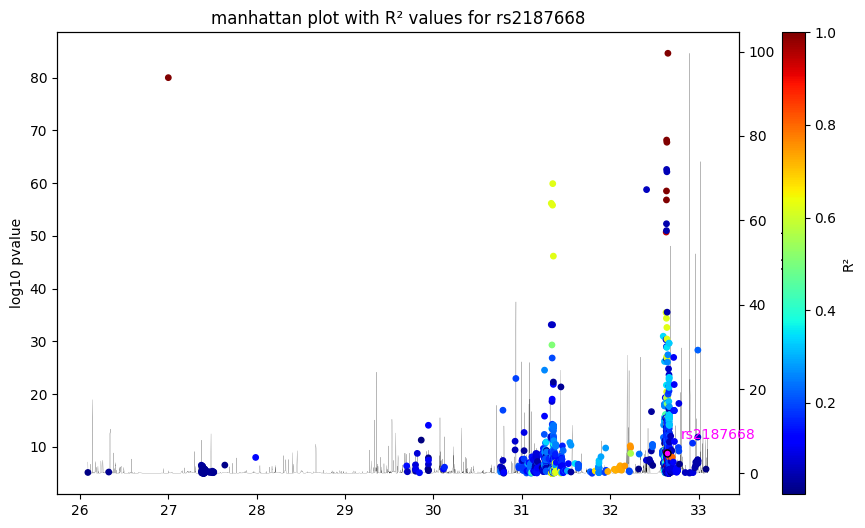

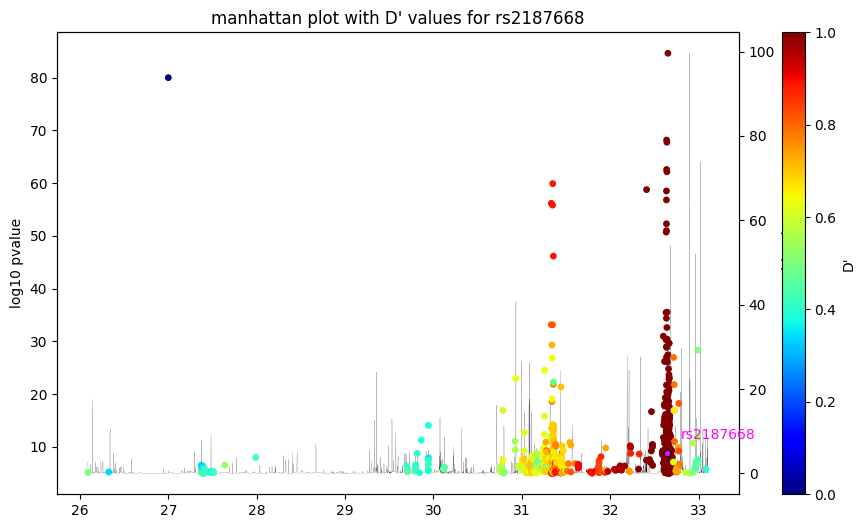

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['pdf.fonttype']=42

# Quick data check
print(link_MHC.head())
data=link_MHC[link_MHC['SNP2'].isin(DQ25)]
data['POS']=data['POS']/1e6
data.loc[5000]={'POS':27,'logp':80,'R2':1,'D':0}

# Point to highlight
highlight_index = 3453  # Index of the point to highlight (zero-based)
highlight_x = data.loc[highlight_index,'POS']
highlight_y = data.loc[highlight_index,'logp']
highlight_text='rs2187668'
# Plot 1: R² vs Position
fig,ax1=plt.subplots(figsize=(11, 6))
# Create a secondary y-axis for R2 values
ax2 = ax1.twinx()
plt.scatter(data['POS'], data['logp'], c=data['R2'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label('R²')
# Highlight the specific point with a different color
ax2.scatter(highlight_x, highlight_y, color='fuchsia', s=25, label='Highlighted Point',edgecolor='k')

# Add a label for the highlighted point
ax2.annotate(highlight_text, (highlight_x, highlight_y), 
             textcoords="offset points", xytext=(10, 10), ha='left', color='fuchsia')

ax2.set_xlabel('Genomic Position (POS) in Mb')
ax2.set_ylabel('log10 pvalue')
plt.title(f'manhattan plot with R² values for {highlight_text}')
plt.xscale('linear')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

ax1.set_ylabel('Recombination', color='k')
ax1.plot(recomb['POS'], recomb['Rate(cM/Mb)'], linestyle='-',linewidth=0.1, color='k', label='Recombination rate')
ax1.tick_params(axis='y', labelcolor='k')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
#plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='y = 0.5')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig('rs2187668_R2_pval.pdf',format='pdf',bbox_inches='tight')
plt.show()

# Plot 2: D vs Position
fig,ax1=plt.subplots(figsize=(11, 6))
# Create a secondary y-axis for R2 values
ax2 = ax1.twinx()

plt.scatter(data['POS'], data['logp'], c=data['D'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label("D'")
# Highlight the specific point with a different color
ax2.scatter(highlight_x, highlight_y, color='fuchsia', s=25, label='Highlighted Point',edgecolor='k')

# Add a label for the highlighted point
ax2.annotate(highlight_text, (highlight_x, highlight_y), 
             textcoords="offset points", xytext=(10, 10), ha='left', color='fuchsia')

ax2.set_xlabel('Genomic Position (POS) in Mb')
ax2.set_ylabel("log10 pvalue")
plt.title(f"manhattan plot with D' values for {highlight_text}")
plt.xscale('linear')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

ax1.set_ylabel('Recombination', color='k')
ax1.plot(recomb['POS'], recomb['Rate(cM/Mb)'], linestyle='-',linewidth=0.1, color='k', label='Recombination rate')
ax1.tick_params(axis='y', labelcolor='k')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
#plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='y = 0.8')
#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig('rs2187668_Dprime_pval.pdf',format='pdf',bbox_inches='tight')

plt.show()

In [ ]:
!pip install openpyxl

In [23]:
#deal with long allele names
link_MHC['SNP_len']=[len(i) for i in link_MHC['SNP2']]
mult_SNP=link_MHC.loc[link_MHC['SNP_len']!=17,'SNP2'].str.split(':',expand=True)
mult_SNP['Ref']=[i[0] for i in mult_SNP[2]]
mult_SNP['Alt']=[i[0] for i in mult_SNP[3]]
mult_SNP['SNP2']=mult_SNP[0]+':'+mult_SNP[1]+':'+mult_SNP['Ref']+':'+mult_SNP['Alt']
link_MHC.loc[link_MHC['SNP_len']!=17,'SNP2']=mult_SNP['SNP2']
link_MHC[link_MHC['SNP_len']!=17]

,SNP1,SNP2,R2,D,R2_1,D_1,R2_2,D_2,POS,p_value,SNP_len
25,chr6:32638107:C:T,chr6:27392402:T:C,0.018555,0.431877,NaN,NaN,NaN,NaN,27392402,8.580000e-06,19
124,chr6:32638107:C:T,chr6:29949251:G:C,0.104977,0.480241,NaN,NaN,NaN,NaN,29949251,9.438000e-06,21
135,chr6:32638107:C:T,chr6:29951243:T:C,0.104792,0.479496,NaN,NaN,NaN,NaN,29951243,7.606200e-06,23
166,chr6:32638107:C:T,chr6:30754526:A:G,0.053030,0.583212,NaN,NaN,NaN,NaN,30754526,4.539100e-06,25
168,chr6:32638107:C:T,chr6:30759162:A:C,0.309370,0.586871,NaN,NaN,NaN,NaN,30759162,4.847800e-06,19
332,chr6:32638107:C:T,chr6:31162816:G:A,0.119421,0.612814,NaN,NaN,NaN,NaN,31162816,6.999300e-08,21
414,chr6:32638107:C:T,chr6:31252250:T:C,0.070810,0.581726,NaN,NaN,NaN,NaN,31252250,3.593800e-06,19
431,chr6:32638107:C:T,chr6:31261083:C:A,0.263091,0.635616,NaN,NaN,NaN,NaN,31261083,2.667700e-07,19
541,chr6:32638107:C:T,chr6:31296805:C:T,0.317720,0.699831,NaN,NaN,NaN,NaN,31296805,1.876100e-12,19
613,chr6:32638107:C:T,chr6:31331523:A:C,0.047769,0.546920,NaN,NaN,NaN,NaN,31331523,4.992000e-09,19


In [ ]:
!gsutil cp LD_plink_with_tag_SNP* $WORKSPACE_BUCKET/data/LD_tag_SNP/

!gsutil cp rs2187668*.pdf $WORKSPACE_BUCKET/data/LD_tag_SNP/

!gsutil cp proxy13728.txt $WORKSPACE_BUCKET/data/LD_tag_SNP/

In [ ]:
import pandas as pd
LDproxy=pd.read_csv('proxy13728.txt',sep='\t')

LDproxy['SNP2']=LDproxy['Coord']+':'+LDproxy['Alleles'].str.replace('(','').str.replace(')','').str.replace('/',':')
LDproxy.rename({'R2':'R2_LDproxy','Dprime':'Dprime_LDproxy'},axis=1,inplace=True)
LD_union=pd.merge(link_MHC,LDproxy[['SNP2','Dprime_LDproxy','R2_LDproxy']],on='SNP2',how='left')
LD_union.drop(['R2_1','D_1','R2_2','D_2'],axis=1,inplace=True)
LD_union.to_csv('LD_rs2187668_Euro_results.csv',index=False)
LD_union[(LD_union['R2_LDproxy']>0.5)&(LD_union['R2']>0.5)]
#1771 available in both
#102 of these have calculated r2>0.5 in both, out of 139 calculated from this data


In [25]:
link_MHC.to_csv('LD_rs2187668_Euro_results.csv',index=False)

In [26]:
rs2187668_union=pd.read_csv('LD_rs2187668_Euro_results.csv')

In [ ]:
!plink --bfile LD_plink_with_tag_SNP --freq --out LD_Euro
!gsutil cp LD_Euro* $WORKSPACE_BUCKET/data/LD_tag_SNP/

In [ ]:
allelefreq=pd.read_csv('LD_Euro.frq',sep='\s+')
allelefreq['Reflen']=[len(i) for i in allelefreq['A1']]
allelefreq['Altlen']=[len(i) for i in allelefreq['A2']]
multi_SNP=allelefreq[~allelefreq['A1'].isin(['A','G','C','T'])&(allelefreq['Reflen']==allelefreq['Altlen'])]
multi_SNP['Ref']=[i[0] for i in multi_SNP['A1']]
multi_SNP['Alt']=[i[0] for i in multi_SNP['A2']]
loc = multi_SNP['SNP'].str.split(':',expand=True)[[0,1]]
locus=loc[0]+':'+loc[1]
SNP2=locus+':'+multi_SNP['Ref']+':'+multi_SNP['Alt']
allelefreq.loc[~allelefreq['A1'].isin(['A','G','C','T'])&(allelefreq['Reflen']==allelefreq['Altlen']),'SNP']=SNP2
allelefreq.rename({'SNP':'SNP2'},axis=1,inplace=True)
Alswitch=LD_union.loc[~LD_union['SNP2'].isin(allelefreq['SNP2']),'SNP2'].str.split(':',expand=True)
LD_union.loc[~LD_union['SNP2'].isin(allelefreq['SNP2']),'SNP2']=Alswitch[0]+':'+Alswitch[1]+':'+Alswitch[3]+':'+Alswitch[2]
LD_union_maf=pd.merge(LD_union,allelefreq[['SNP2','MAF','NCHROBS']],on='SNP2')
LD_union_maf.to_csv('LD_MAF_rs2187668.csv',index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame (replace with your actual data)
data = pd.DataFrame({
    'Position (Mb)': [32.2, 32.4, 32.6, 32.8, 33.0],
    'Recombination Rate (cM/Mb)': [0.4, 0.5, 0.3, 0.6, 0.7],
    'R2': [0.8, 0.7, 0.9, 0.6, 0.5]
})

# Create the primary plot for Recombination Rate
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Chromosome Coordinate (Mb)')
ax1.set_ylabel('Recombination Rate (cM/Mb)', color='tab:blue')
ax1.plot(data['Position (Mb)'], data['Recombination Rate (cM/Mb)'], marker='o', linestyle='-', color='tab:blue', label='Recombination Rate')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for R2 values
ax2 = ax1.twinx()
ax2.set_ylabel('R²', color='tab:red')
ax2.plot(data['Position (Mb)'], data['R2'], marker='s', linestyle='--', color='tab:red', label='R²')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add titles and grid
plt.title('Recombination Rate and R² Values Across Genomic Position')
fig.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.rcParams['pdf.fonttype']=42
link_MHC=pd.read_csv('LD_MAF_rs2187668.csv')
# Quick data check
print(link_MHC.head())
data=link_MHC[link_MHC['MAF']<=0.18]

# Point to highlight
highlight_index = 3453  # Index of the point to highlight (zero-based)
highlight_x =32638107
highlight_y = -np.log10(0.0000000012149)
highlight_text='rs2187668'
# Plot 1: R² vs Position
plt.figure(figsize=(11, 6))
plt.scatter(data['POS'], data['logp'], c=data['R2'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label('R²')
# Highlight the specific point with a different color
plt.scatter(highlight_x, highlight_y, color='fuchsia', s=25, label='Highlighted Point',edgecolor='k')

# Add a label for the highlighted point
plt.annotate(highlight_text, (highlight_x, highlight_y), 
             textcoords="offset points", xytext=(10, 10), ha='left', color='fuchsia')

plt.xlabel('Genomic Position (POS)')
plt.ylabel('log10 pvalue')
plt.title(f'{highlight_text} manhattan plot with R² values')
plt.xscale('linear')
#plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='y = 0.5')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig('rs2187668_R2_pval_less_maf.pdf',format='pdf',bbox_inches='tight')
plt.show()

# Plot 2: D vs Position
plt.figure(figsize=(11, 6))
plt.scatter(data['POS'], data['logp'], c=data['D'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label("D'")
# Highlight the specific point with a different color
plt.scatter(highlight_x, highlight_y, color='fuchsia', s=25, label='Highlighted Point',edgecolor='k')

# Add a label for the highlighted point
plt.annotate(highlight_text, (highlight_x, highlight_y), 
             textcoords="offset points", xytext=(10, 10), ha='left', color='fuchsia')

plt.xlabel('Genomic Position (POS)')
plt.ylabel("log10 pvalue")
plt.title(f"{highlight_text} manhattan plot with D' values")
plt.xscale('linear')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
#plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='y = 0.8')
#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig('rs2187668_Dprime_pval_less_maf.pdf',format='pdf',bbox_inches='tight')

plt.show()

## DQ8

In [ ]:
#filter for SNPs in low LD with DQ2.5
DQ8_list=link_all.loc[(link_all['SNP2'].isin(gwas_res['SNP2'])&link_all['SNP2'].str.contains('chr6:2|chr6:3')&(link_all['D']<0.7))|(link_all['SNP2']=='chr6:32713706:T:C'),'SNP2']
DQ8_list.to_csv('DQ8_snps_list.txt',index=False,header=None)

In [ ]:
!grep chr6:32713706:T:C LD_plink_with_tag_SNP.bim

In [ ]:
%%bash


rm DQ8_snp_ld_results.txt
rm DQ8_snp_ld_results_alt.txt
echo "SNP1 SNP2 R2 D" > DQ8_snp_ld_results.txt
echo "SNP2 R2_1 D_1 R2_2 D_2" > DQ8_snp_ld_results_alt.txt
#plink --bfile LD_plink_with_tag_SNP --r2 --chr 6 --ld-window-kb 99999 --ld-window 99999 --from-bp 26000000 --to-bp 35000000 --out DQ_25_LD
for SNP in $(awk '{print $2}' LD_plink_with_tag_SNP.bim)
 do
   echo $SNP
   plink --bfile LD_plink_with_tag_SNP_ced --ld chr6:32713706:T:C ${SNP} > ld_output.txt
   awk -v var2="chr6:32713706:T:C" -v var3="${SNP}" '{if(NR == 21) print var2, var3,$3,$6}' ld_output.txt >> DQ8_snp_ld_results.txt
   awk -v v2="${SNP}" '{if(NR == 29) val1 = $3 " " $6; if(NR == 41) val2 = $3 " " $6} END {print v2, val1, val2}' ld_output.txt >> DQ8_snp_ld_results_alt.txt
   
   rm ld_output.txt
   tail  DQ8_snp_ld_results_alt.txt
 done

In [ ]:
!tail  DQ8_snp_ld_results.txt

In [ ]:
!plink --bfile LD_plink_with_tag_SNP --ld chr6:32685657:G:C chr6:32690302:T:C #| awk -v var2="chr6:32713706:T:C" -v var3="${SNP}" '{if(NR == 21) print var2, var3,$3,$6}'

In [ ]:
!gsutil cp DQ8_snp_ld_results.txt {bucket}/data/LD_tag_SNP/

In [ ]:
link=pd.read_csv(f'DQ8_snp_ld_results.txt',sep='\s')

In [ ]:
link_alt=pd.read_csv('DQ8_snp_ld_results_alt.txt',sep='\s')

link_all=pd.merge(link,link_alt,on='SNP2')
link_all.to_csv(f'{bucket}/data/LD_tag_SNP/DQ8_linkage.csv',index=False)

In [61]:
import numpy as np
link_all=pd.read_csv(f'{bucket}/data/LD_tag_SNP/DQ8_linkage.csv')
link_all.loc[(link_all['R2_1']<link_all['R2_2']),'R2']=link_all.loc[(link_all['R2_1']<link_all['R2_2']),'R2_2'].to_list()
link_all.loc[(link_all['R2_1']<link_all['R2_2']),'D']=link_all.loc[(link_all['R2_1']<link_all['R2_2']),'D_2'].to_list()

link_all.loc[(link_all['R2_1']>link_all['R2_2']),'R2']=link_all.loc[(link_all['R2_1']>link_all['R2_2']),'R2_1'].to_list()
link_all.loc[(link_all['R2_1']>link_all['R2_2']),'D']=link_all.loc[(link_all['R2_1']>link_all['R2_2']),'D_1'].to_list()

link_all['R2']=link_all['R2'].astype(float)
#link_all.loc[5000]={'SNP1':'chr6:32638107:C:T','SNP2':'chr6:32638107:C:T','R2':1,'D':1}
link_all['POS']=link_all['SNP2'].str.split(':',expand=True)[1].astype(int)
link_MHC=pd.merge(link_all,gwas_res[['SNP2','p_value']],on='SNP2').drop(0)
link_MHC['logp']=-np.log10(link_MHC['p_value'])

In [ ]:
link_MHC[link_MHC['SNP2']==]

In [ ]:
link_MHC#[link_MHC['SNP2']=='chr6:32638107:C:T']

In [ ]:
%%writefile test.txt
chr6:32713706:T:C
chr6:32638107:C:T

In [ ]:
!plink --bfile LD_plink_with_tag_SNP --extract test.txt --recode --out test_genotypes

In [65]:
data['R2'].sort_values(ascending=False)#SNP2']!='chr6:34081891:A:T']

2858    0.659167
2857    0.654945
2934    0.654510
2645    0.654510
2996    0.654510
          ...   
2151    0.002042
1999    0.002004
2346    0.001927
2722    0.001467
1157    0.000748
Name: R2, Length: 1830, dtype: float64

                SNP1               SNP2        R2         D  R2_1  D_1  R2_2  \
1  chr6:32713706:T:C  chr6:26090042:G:C  0.000053  0.009103   NaN  NaN   NaN   
2  chr6:32713706:T:C  chr6:26090042:G:T  0.008360  0.793393   NaN  NaN   NaN   
3  chr6:32713706:T:C  chr6:26326086:G:A  0.004469  0.135023   NaN  NaN   NaN   
4  chr6:32713706:T:C  chr6:26326086:G:C  0.008809  0.761357   NaN  NaN   NaN   
5  chr6:32713706:T:C  chr6:26328125:T:C  0.008876  0.763066   NaN  NaN   NaN   

   D_2       POS       p_value       logp  
1  NaN  26090042  6.974600e-06   5.156481  
2  NaN  26090042  1.903300e-07   6.720493  
3  NaN  26326086  5.838200e-06   5.233721  
4  NaN  26326086  1.089600e-13  12.962733  
5  NaN  26328125  3.589200e-06   5.445002  


/tmp/ipykernel_146/2641618330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['POS']=data['POS']/1e6


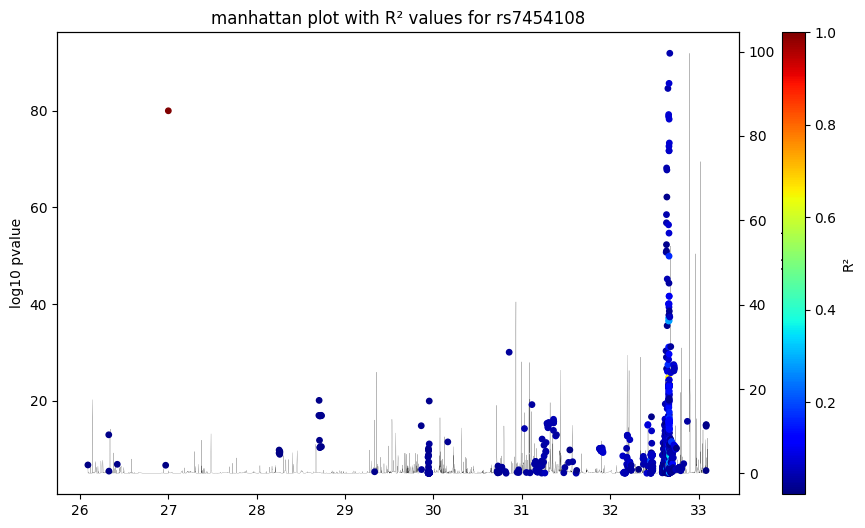

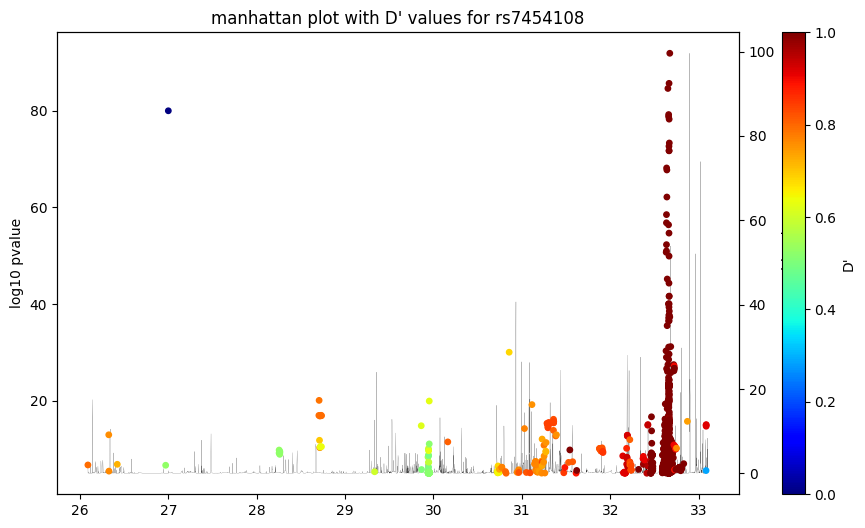

In [67]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['pdf.fonttype']=42

# Quick data check
print(link_MHC.head())
data=link_MHC[link_MHC['SNP2'].isin(DQ8)]
data['POS']=data['POS']/1e6
data=data[data['SNP2']!='chr6:34081891:A:T']
highlight_text='rs7454108'

data.loc[5000]={'POS':27,'logp':80,'R2':1,'D':0}
# Plot 1: R² vs Position
fig,ax1=plt.subplots(figsize=(11, 6))
# Create a secondary y-axis for R2 values
ax2 = ax1.twinx()
plt.scatter(data['POS'], data['logp'], c=data['R2'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label('R²')
ax2.set_xlabel('Genomic Position (POS) in Mb')
ax2.set_ylabel('log10 pvalue')
plt.title(f'manhattan plot with R² values for {highlight_text}')
plt.xscale('linear')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

ax1.set_ylabel('Recombination', color='k')
ax1.plot(recomb['POS'], recomb['Rate(cM/Mb)'], linestyle='-',linewidth=0.1, color='k', label='Recombination rate')
ax1.tick_params(axis='y', labelcolor='k')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
#plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='y = 0.5')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig(f'{highlight_text}_R2_pval_max.pdf',format='pdf',bbox_inches='tight')
plt.show()

# Plot 2: D vs Position
fig,ax1=plt.subplots(figsize=(11, 6))
# Create a secondary y-axis for R2 values
ax2 = ax1.twinx()

plt.scatter(data['POS'], data['logp'], c=data['D'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label("D'")
ax2.set_xlabel('Genomic Position (POS) in Mb')
ax2.set_ylabel("log10 pvalue")
plt.title(f"manhattan plot with D' values for {highlight_text}")
plt.xscale('linear')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

ax1.set_ylabel('Recombination', color='k')
ax1.plot(recomb['POS'], recomb['Rate(cM/Mb)'], linestyle='-',linewidth=0.1, color='k', label='Recombination rate')
ax1.tick_params(axis='y', labelcolor='k')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
#plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='y = 0.8')
#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig(f'{highlight_text}_Dprime_pval_max.pdf',format='pdf',bbox_inches='tight')

plt.show()

In [ ]:
data

In [16]:
#deal with long allele names
link_MHC['SNP_len']=[len(i) for i in link_MHC['SNP2']]
mult_SNP=link_MHC.loc[link_MHC['SNP_len']!=17,'SNP2'].str.split(':',expand=True)
mult_SNP['Ref']=[i[0] for i in mult_SNP[2]]
mult_SNP['Alt']=[i[0] for i in mult_SNP[3]]
mult_SNP['SNP2']=mult_SNP[0]+':'+mult_SNP[1]+':'+mult_SNP['Ref']+':'+mult_SNP['Alt']
link_MHC.loc[link_MHC['SNP_len']!=17,'SNP2']=mult_SNP['SNP2']
link_MHC[link_MHC['SNP_len']!=17]

,SNP1,SNP2,R2,D,R2_1,D_1,R2_2,D_2,POS,p_value,logp,SNP_len
25,chr6:32713706:T:C,chr6:27392402:T:C,0.000028,0.029505,NaN,NaN,NaN,NaN,27392402,8.580000e-06,5.066513,19
124,chr6:32713706:T:C,chr6:29949251:G:C,0.025446,0.518427,NaN,NaN,NaN,NaN,29949251,9.438000e-06,5.025120,21
135,chr6:32713706:T:C,chr6:29951243:T:C,0.026129,0.526593,NaN,NaN,NaN,NaN,29951243,7.606200e-06,5.118832,23
166,chr6:32713706:T:C,chr6:30754526:A:G,0.000611,0.110396,NaN,NaN,NaN,NaN,30754526,4.539100e-06,5.343030,25
168,chr6:32713706:T:C,chr6:30759162:A:C,0.016394,0.651556,NaN,NaN,NaN,NaN,30759162,4.847800e-06,5.314455,19
332,chr6:32713706:T:C,chr6:31162816:G:A,0.003442,0.159459,NaN,NaN,NaN,NaN,31162816,6.999300e-08,7.154945,21
414,chr6:32713706:T:C,chr6:31252250:T:C,0.000205,0.055515,NaN,NaN,NaN,NaN,31252250,3.593800e-06,5.444446,19
431,chr6:32713706:T:C,chr6:31261083:C:A,0.007550,0.337810,NaN,NaN,NaN,NaN,31261083,2.667700e-07,6.573863,19
541,chr6:32713706:T:C,chr6:31296805:C:T,0.044174,0.819589,NaN,NaN,NaN,NaN,31296805,1.876100e-12,11.726744,19
613,chr6:32713706:T:C,chr6:31331523:A:C,0.002313,0.212315,NaN,NaN,NaN,NaN,31331523,4.992000e-09,8.301725,19


In [18]:
LD_union_8#=pd.merge(link_MHC,LDproxy[['SNP2','Dprime_LDproxy','R2_LDproxy']],on='SNP2',how='left')
highlight_text='rs7454108'

In [19]:
import pandas as pd
LDproxy=pd.read_csv('DQ8_proxy.txt',sep='\t')

LDproxy['SNP2']=LDproxy['Coord']+':'+LDproxy['Alleles'].str.replace('(','').str.replace(')','').str.replace('/',':')
LDproxy.rename({'R2':'R2_LDproxy','Dprime':'Dprime_LDproxy'},axis=1,inplace=True)
LD_union_8=pd.merge(link_MHC,LDproxy[['SNP2','Dprime_LDproxy','R2_LDproxy']],on='SNP2',how='left')
LD_union_8.to_csv(f'LD_{highlight_text}_Euro_results.csv',index=False)
LD_union_8[(LD_union_8['Dprime_LDproxy']>0.7)&(LD_union_8['D']>0.7)&~pd.isna(LD_union_8['Dprime_LDproxy'])]
#86 available in both
#70 of these have calculated D'>0.6 in both, out of 71 calculated from this data


,SNP1,SNP2,R2,D,R2_1,D_1,R2_2,D_2,POS,p_value,logp,SNP_len,Dprime_LDproxy,R2_LDproxy
1016,chr6:32713706:T:C,chr6:31869050:T:G,0.046134,0.833901,NaN,NaN,NaN,NaN,31869050,5.894800e-11,10.229531,17,0.7520,0.0198
1031,chr6:32713706:T:C,chr6:31872244:T:A,0.051670,0.845065,NaN,NaN,NaN,NaN,31872244,2.129700e-12,11.671682,17,0.7669,0.0223
1033,chr6:32713706:T:C,chr6:31873017:C:T,0.060908,0.805669,NaN,NaN,NaN,NaN,31873017,3.981000e-08,7.400008,17,0.7101,0.0334
1035,chr6:32713706:T:C,chr6:31879235:C:A,0.052834,0.822232,NaN,NaN,NaN,NaN,31879235,8.286800e-11,10.081613,17,0.7582,0.0256
1036,chr6:32713706:T:C,chr6:31879419:T:C,0.052834,0.822232,NaN,NaN,NaN,NaN,31879419,8.215900e-11,10.085345,17,0.7582,0.0256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,chr6:32713706:T:C,chr6:32785067:A:G,0.032563,1.000000,NaN,NaN,NaN,NaN,32785067,7.337700e-07,6.134440,17,1.0000,0.0105
3209,chr6:32713706:T:C,chr6:32787513:T:C,0.032563,1.000000,NaN,NaN,NaN,NaN,32787513,6.756500e-07,6.170278,17,1.0000,0.0105
3210,chr6:32713706:T:C,chr6:32788876:C:T,0.032563,1.000000,NaN,NaN,NaN,NaN,32788876,5.990600e-07,6.222530,17,1.0000,0.0105
3211,chr6:32713706:T:C,chr6:32797808:G:T,0.032321,1.000000,NaN,NaN,NaN,NaN,32797808,2.980800e-06,5.525667,17,1.0000,0.0106


In [21]:
LD_union_8=pd.read_csv('LD_rs7454108_Euro_results.csv')

,SNP1,SNP2,R2,D,R2_1,D_1,R2_2,D_2,POS,p_value,logp,SNP_len,Dprime_LDproxy,R2_LDproxy
0,chr6:32713706:T:C,chr6:26090042:G:C,0.000053,0.009103,NaN,NaN,NaN,NaN,26090042,6.974600e-06,5.156481,17,NaN,NaN
1,chr6:32713706:T:C,chr6:26090042:G:T,0.008360,0.793393,NaN,NaN,NaN,NaN,26090042,1.903300e-07,6.720493,17,NaN,NaN
2,chr6:32713706:T:C,chr6:26326086:G:A,0.004469,0.135023,NaN,NaN,NaN,NaN,26326086,5.838200e-06,5.233721,17,NaN,NaN
3,chr6:32713706:T:C,chr6:26326086:G:C,0.008809,0.761357,NaN,NaN,NaN,NaN,26326086,1.089600e-13,12.962733,17,NaN,NaN
4,chr6:32713706:T:C,chr6:26328125:T:C,0.008876,0.763066,NaN,NaN,NaN,NaN,26328125,3.589200e-06,5.445002,17,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,chr6:32713706:T:C,chr6:33089934:G:A,0.004886,0.280948,NaN,NaN,NaN,NaN,33089934,9.681400e-06,5.014062,17,NaN,NaN
3449,chr6:32713706:T:C,chr6:33090058:C:T,0.004940,0.282282,NaN,NaN,NaN,NaN,33090058,9.542200e-06,5.020351,17,NaN,NaN
3450,chr6:32713706:T:C,chr6:33095626:A:G,0.004940,0.282282,NaN,NaN,NaN,NaN,33095626,8.710200e-06,5.059972,17,NaN,NaN
3451,chr6:32713706:T:C,chr6:33105545:A:G,0.005101,0.286261,NaN,NaN,NaN,NaN,33105545,8.895800e-06,5.050815,17,NaN,NaN


In [ ]:
allelefreq=pd.read_csv('LD_Euro.frq',sep='\s+')
allelefreq['Reflen']=[len(i) for i in allelefreq['A1']]
allelefreq['Altlen']=[len(i) for i in allelefreq['A2']]
multi_SNP=allelefreq[~allelefreq['A1'].isin(['A','G','C','T'])&(allelefreq['Reflen']==allelefreq['Altlen'])]
multi_SNP['Ref']=[i[0] for i in multi_SNP['A1']]
multi_SNP['Alt']=[i[0] for i in multi_SNP['A2']]
loc = multi_SNP['SNP'].str.split(':',expand=True)[[0,1]]
locus=loc[0]+':'+loc[1]
SNP2=locus+':'+multi_SNP['Ref']+':'+multi_SNP['Alt']
allelefreq.loc[~allelefreq['A1'].isin(['A','G','C','T'])&(allelefreq['Reflen']==allelefreq['Altlen']),'SNP']=SNP2
allelefreq.rename({'SNP':'SNP2'},axis=1,inplace=True)

Alswitch=LD_union_8.loc[~LD_union_8['SNP2'].isin(allelefreq['SNP2']),'SNP2'].str.split(':',expand=True)

LD_union_8.loc[~LD_union_8['SNP2'].isin(allelefreq['SNP2']),'SNP2']=Alswitch[0]+':'+Alswitch[1]+':'+Alswitch[3]+':'+Alswitch[2]
LD_union_8_maf=pd.merge(LD_union_8,allelefreq[['SNP2','MAF','NCHROBS']],on='SNP2')
LD_union_8_maf.to_csv(f'LD_MAF_{highlight_text}.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

LD_union_8_maf = pd.read_csv('LD_MAF_rs7454108.csv')

plt.rcParams['pdf.fonttype']=42

# Quick data check
print(LD_union_8_maf.head())
data=LD_union_8_maf[(LD_union_8_maf['MAF']<=0.15)]


highlight_text='rs7454108'
# Plot 1: R² vs Position
plt.figure(figsize=(11, 6))
plt.scatter(data['POS'], data['logp'], c=data['R2'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label('R²')
plt.xlabel('Genomic Position (POS)')
plt.ylabel('log10 pvalue')
plt.title(f'manhattan plot with R² values for {highlight_text}')
plt.xscale('linear')
#plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='y = 0.5')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig(f'{highlight_text}_R2_pval_maf_less.pdf',format='pdf',bbox_inches='tight')
plt.show()

# Plot 2: D vs Position
plt.figure(figsize=(11, 6))
plt.scatter(data['POS'], data['logp'], c=data['D'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label("D'")
plt.xlabel('Genomic Position (POS)')
plt.ylabel("log10 pvalue")
plt.title(f"manhattan plot with D' values for {highlight_text}")
plt.xscale('linear')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
#plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='y = 0.8')
#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig(f'{highlight_text}_Dprime_pval_maf_less.pdf',format='pdf',bbox_inches='tight')

plt.show()

## DQ2.2

In [ ]:
%%bash

wget https://faculty.washington.edu/browning/beagle/beagle.28Jun21.220.jar
#haplotype
plink --bfile LD_plink_with_tag_SNP --chr 6 --recode vcf --out DQ22_haplo_freq
java -jar beagle.28Jun21.220.jar gt=DQ22_haplo_freq.vcf out=phased_data
gunzip phased_data.vcf.gz

In [ ]:
import pandas as pd
import os,io

def read_vcf(path):
      with open(path, 'r') as f:
          lines = [l for l in f if not l.startswith('##')]
      return pd.read_csv(
          io.StringIO(''.join(lines)),
          dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
                 'QUAL': str, 'FILTER': str, 'INFO': str},
          sep='\t'
      ).rename(columns={'#CHROM': 'chrom' })

file = read_vcf('phased_data.vcf')
hap=file[file['ID'].isin(["chr6:32445540:G:T","chr6:32690302:T:C","chr6:32691805:A:G"])]

# Split all columns except the first 9 (example: here we only have fewer columns for illustration)
num_metadata_columns = 9  # Adjust this to 9 as per your case

# Select columns to split
columns_to_split = hap.columns[num_metadata_columns:]

# Loop through the columns and split each into two new columns
for col in columns_to_split:
    hap[[f"{col}_a1", f"{col}_a2"]] = hap[col].str.split('|', expand=True)

# Drop the original columns if needed
hap = hap.drop(columns=columns_to_split)


hap_rows=hap.set_index(['ID']).drop(['chrom', 'POS','REF','ALT', 'QUAL', 'FILTER','FORMAT', 'INFO'],axis=1).T
hap_rows[(hap_rows['chr6:32445540:G:T']=='0')&(hap_rows['chr6:32690302:T:C']=='1')&(hap_rows['chr6:32691805:A:G']=='0')]

hap_rows['DQ2.2']=0
hap_rows.loc[(hap_rows['chr6:32445540:G:T']=='0')&(hap_rows['chr6:32690302:T:C']=='1')&(hap_rows['chr6:32691805:A:G']=='0'),'DQ2.2']=1


hap_rows.loc[hap_rows.index.str.contains('a1'),'allele']=1
hap_rows.loc[hap_rows.index.str.contains('a2'),'allele']=2
hap_rows.reset_index(inplace=True)

hap_rows['index']=hap_rows['index'].str.replace('0_','').str.replace('a1','').str.replace('a2','').str.replace('_','')

DQ22_res=hap_rows.reset_index().pivot('index','allele','DQ2.2').reset_index().drop_duplicates('index')
DQ22_res[1].replace([0,1],['A','T'],inplace=True)
DQ22_res[2].replace([0,1],['A','T'],inplace=True)

DQ22_res['DQ2.2']=DQ22_res[1].astype(str)+' '+DQ22_res[2].astype(str)
DQ22_res[['FID','PID','MID','Sex','Phenotype']]=0
DQ22_res[['FID','index','PID', 'MID', 'Sex', 'Phenotype','DQ2.2']].to_csv('imputed_snps.ped', sep=' ', index=False, header=False)

# Create .map file manually (example)
map_data = pd.DataFrame({
    'CHR': [6],  # Chromosome number
    'SNP': ['DQ2.2'],  # SNP ID
    'Genetic_dist': [0],  # Genetic distance (use 0 if unknown)
    'BP': [123456]  # Base-pair positions
})
map_data.to_csv('imputed_snps.map', sep=' ', index=False, header=False)


In [ ]:
%%bash
vcftools --vcf phased_data.vcf --snps gwas_SNPs.txt --recode --out filtered_output
bgzip your_file.vcf

In [ ]:
%%bash
# If your existing data is in binary format (.bed, .bim, .fam):
plink --file imputed_snps --make-bed --out imputed_snps_binary
plink --bfile LD_plink_with_tag_SNP --bmerge imputed_snps_binary --make-bed --out LD_plink_with_DQ22


In [ ]:
!gsutil ls $WORKSPACE_BUCKET/data/LD_tag_SNP

In [ ]:
%%bash

rm DQ22_hap_ld_results.txt
rm DQ22_hap_ld_results_alt.txt
echo "SNP1 SNP2 R2 D" > DQ22_hap_ld_results.txt
echo "SNP1 SNP2 R2_1 D_1 R2_2 D_2" > DQ22_hap_ld_results_alt.txt
#plink --bfile LD_plink_with_tag_SNP --r2 --chr 6 --ld-window-kb 99999 --ld-window 99999 --from-bp 26000000 --to-bp 35000000 --out DQ_25_LD
for SNP in $(awk '{print $2}' LD_plink_with_DQ22.bim)
 do
   echo $SNP
   plink --bfile LD_plink_with_DQ22 --keep eur_ced.txt --ld DQ2.2 ${SNP} > ld_output.txt
   awk -v var2="DQ2.2" -v var3="${SNP}" '{if(NR == 23) print var2, var3,$3,$6}' ld_output.txt >> DQ22_hap_ld_results.txt
   awk -v var2="DQ2.2" -v v2="${SNP}" '{if(NR == 31) val1 = $3 " " $6; if(NR == 43) val2 = $3 " " $6} END {print var2,v2, val1, val2}' ld_output.txt >> DQ22_hap_ld_results_alt.txt
   rm ld_output.txt
   #tail  DQ22_hap_ld_results.txt
 done

In [ ]:
!plink --bfile LD_plink_with_DQ22 --keep eur_ced.txt --ld DQ2.2 chr3:196717487:A:G #> ld_output.txt
!awk -v var2="DQ2.2" -v var3="chr1:221607617:T:C" '{if(NR == 31) print var2, var3,$3,$6}' ld_output.txt

In [ ]:
%%bash

rm DQ22_snp_ld_results.txt
rm DQ22_snp_ld_results_alt.txt
echo "SNP1 SNP2 R2 D" > DQ22_snp_ld_results.txt
echo "SNP1 SNP2 R2_1 D_1 R2_2 D_2" > DQ22_snp_ld_results_alt.txt
#plink --bfile LD_plink_with_tag_SNP --r2 --chr 6 --ld-window-kb 99999 --ld-window 99999 --from-bp 26000000 --to-bp 35000000 --out DQ_25_LD
for SNP in $(awk '{print $2}' LD_plink_with_tag_SNP.bim)
 do
   echo $SNP
   plink --bfile LD_plink_with_tag_SNP --ld chr6:32445540:G:T ${SNP} > ld_output.txt
   awk -v var2="chr6:32445540:G:T" -v var3="${SNP}" '{if(NR == 21) print var2, var3,$3,$6}' ld_output.txt >> DQ22_snp_ld_results.txt
   awk -v var2="chr6:32445540:G:T" -v v2="${SNP}" '{if(NR == 29) val1 = $3 " " $6; if(NR == 41) val2 = $3 " " $6} END {print var2,v2, val1, val2}' ld_output.txt >> DQ22_snp_ld_results_alt.txt
   rm ld_output.txt
   plink --bfile LD_plink_with_tag_SNP --ld chr6:32690302:T:C ${SNP} > ld_output.txt
   awk -v var2="chr6:32690302:T:C" -v var3="${SNP}" '{if(NR == 21) print var2, var3,$3,$6}' ld_output.txt >> DQ22_snp_ld_results.txt
   awk -v var2="chr6:32690302:T:C" -v v2="${SNP}" '{if(NR == 29) val1 = $3 " " $6; if(NR == 41) val2 = $3 " " $6} END {print var2,v2, val1, val2}' ld_output.txt >> DQ22_snp_ld_results_alt.txt
   rm ld_output.txt
   plink --bfile LD_plink_with_tag_SNP --ld chr6:32691805:A:G ${SNP} > ld_output.txt
   awk -v var2="chr6:32691805:A:G" -v var3="${SNP}" '{if(NR == 21) print var2, var3,$3,$6}' ld_output.txt >> DQ22_snp_ld_results.txt
   awk -v var2="chr6:32691805:A:G" -v v2="${SNP}" '{if(NR == 29) val1 = $3 " " $6; if(NR == 41) val2 = $3 " " $6} END {print var2, v2, val1, val2}' ld_output.txt >> DQ22_snp_ld_results_alt.txt
   rm ld_output.txt
   tail  DQ22_snp_ld_results.txt
 done

In [ ]:
!grep chr6:30162257:C:A  DQ22_snp_ld_results_alt.txt

In [ ]:
link=pd.read_csv(f'DQ22_snp_ld_results.txt',sep='\s')
link[link['R2']=='be']

In [6]:
link=pd.read_csv(f'DQ22_hap_ld_results.txt',sep='\s')
link[link['R2']=='be']

/tmp/ipykernel_146/4059880370.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  link=pd.read_csv(f'DQ22_hap_ld_results.txt',sep='\s')


,SNP1,SNP2,R2,D
26,DQ2.2,chr2:230260869:CGTG:TGTG,be,NaN
39,DQ2.2,chr3:196717487:A:G,be,NaN
40,DQ2.2,chr3:196717750:C:T,be,NaN
41,DQ2.2,chr3:196720819:A:T,be,NaN
42,DQ2.2,chr3:196722910:G:A,be,NaN
...,...,...,...,...
3760,DQ2.2,chr6:32873319:T:TTTTATTTATTTA,be,NaN
3784,DQ2.2,chr6:32993169:T:A,be,NaN
4011,DQ2.2,chr7:108250650:CA:C,be,NaN
4025,DQ2.2,chr9:116996613:A:T,be,NaN


In [ ]:
link_alt=pd.read_csv('DQ22_snp_ld_results_alt.txt',sep='\s')

link_all=pd.merge(link,link_alt,on=['SNP1','SNP2'])
link_all.to_csv(f'{bucket}/data/LD_tag_SNP/DQ22_linkage.csv',index=False)

In [ ]:
link_alt

In [7]:
link_alt=pd.read_csv('DQ22_hap_ld_results_alt.txt',sep='\s')

link_all=pd.merge(link,link_alt,on=['SNP1','SNP2'])
link_all.to_csv(f'{bucket}/data/LD_tag_SNP/DQ22_hap_linkage.csv',index=False)

/tmp/ipykernel_146/3807615935.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  link_alt=pd.read_csv('DQ22_hap_ld_results_alt.txt',sep='\s')


In [ ]:
import numpy as np
link_all=pd.read_csv(f'{bucket}/data/LD_tag_SNP/DQ22_linkage.csv')
link_all.loc[(link_all['R2_1']<link_all['R2_2']),'R2']=link_all.loc[(link_all['R2_1']<link_all['R2_2']),'R2_2'].to_list()
link_all.loc[(link_all['R2_1']<link_all['R2_2']),'D']=link_all.loc[(link_all['R2_1']<link_all['R2_2']),'D_2'].to_list()

link_all.loc[(link_all['R2_1']>link_all['R2_2']),'R2']=link_all.loc[(link_all['R2_1']>link_all['R2_2']),'R2_1'].to_list()
link_all.loc[(link_all['R2_1']>link_all['R2_2']),'D']=link_all.loc[(link_all['R2_1']>link_all['R2_2']),'D_1'].to_list()
link_all[link_all['R2']=='be']

In [68]:
import numpy as np
link_all=pd.read_csv(f'{bucket}/data/LD_tag_SNP/DQ22_hap_linkage.csv')
link_all.loc[(link_all['R2_1']<link_all['R2_2']),'R2']=link_all.loc[(link_all['R2_1']<link_all['R2_2']),'R2_2'].to_list()

link_all.loc[(link_all['R2_1']<link_all['R2_2']),'D']=link_all.loc[(link_all['R2_1']<link_all['R2_2']),'D_2'].to_list()

link_all.loc[(link_all['R2_1']>link_all['R2_2']),'R2']=link_all.loc[(link_all['R2_1']>link_all['R2_2']),'R2_1'].to_list()
link_all.loc[(link_all['R2_1']>link_all['R2_2']),'D']=link_all.loc[(link_all['R2_1']>link_all['R2_2']),'D_1'].to_list()
link_all[link_all['R2']=='be']

,SNP1,SNP2,R2,D,R2_1,D_1,R2_2,D_2


In [ ]:
%%writefile af_check_eur.txt
chr6:32665979:C:T
chr6:32661238:G:T
chr6:32660728:T:A

In [ ]:
!plink --bfile LD_plink_with_tag_SNP --extract af_check_eur.txt --recode --out check_freq #| awk -v v2="chr6:30162257:C:A" '{if(NR == 29) val1 = $3 " " $6; if(NR == 41) val2 = $3 " " $6} END {print v2, val1, val2}'

In [9]:
link_all

,SNP1,SNP2,R2,D,R2_1,D_1,R2_2,D_2
0,DQ2.2,chr1:47150227:G:T,0.00022696,0.024082,NaN,NaN,NaN,NaN
1,DQ2.2,chr1:47155607:T:A,0.00022696,0.024082,NaN,NaN,NaN,NaN
2,DQ2.2,chr1:221607617:T:C,0.000143709,0.234909,NaN,NaN,NaN,NaN
3,DQ2.2,chr1:236151286:C:T,6.37412e-05,0.079111,NaN,NaN,NaN,NaN
4,DQ2.2,chr2:3765493:T:C,0.000934022,0.124920,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4079,DQ2.2,chr21:42022276:C:T,0.00167567,0.049603,NaN,NaN,NaN,NaN
4080,DQ2.2,chr21:42022619:A:G,0.00167567,0.049603,NaN,NaN,NaN,NaN
4081,DQ2.2,chr21:42022620:C:A,0.00167567,0.049603,NaN,NaN,NaN,NaN
4082,DQ2.2,chr21:42022658:G:A,0.00167567,0.049603,NaN,NaN,NaN,NaN


In [69]:
link_all['R2']=link_all['R2'].astype(float)
#link_all.loc[5000]={'SNP1':'chr6:32638107:C:T','SNP2':'chr6:32638107:C:T','R2':1,'D':1}
link_all['POS']=link_all['SNP2'].str.split(':',expand=True)[1].astype(int)
link_MHC=pd.merge(link_all,gwas_res[['SNP2','p_value']],on='SNP2').drop(0)
link_MHC['logp']=-np.log10(link_MHC['p_value'])

In [ ]:
#there are 3 tag SNPs for dq2.2, how to deal with this?
link2=link_all.pivot(values='R2',index='SNP2',columns='SNP1').reset_index()
link2['chr6:32445540:G:T'].fillna(1,inplace=True)

In [ ]:
link_MHC_22[(link_MHC_22['chr6:32445540:G:T']>0.7)|(link_MHC_22['chr6:32690302:T:C']>0.7)|(link_MHC_22['chr6:32691805:A:G']>0.7)]

In [ ]:
import numpy as np
link2['POS']=link2['SNP2'].str.split(':',expand=True)[1].astype(int)
link_MHC_22=pd.merge(link2,gwas_res[['SNP2','p_value']],on='SNP2').drop(0)
link_MHC_22['logp']=-np.log10(link_MHC_22['p_value'])

In [ ]:
link_MHC_22.to_csv('DQ22_tag_SNPs.csv',index=False)

In [11]:
link_MHC.to_csv('DQ22_tag_hap.csv',index=False)

In [13]:
link_MHC_22=pd.read_csv('DQ22_tag_hap.csv')

,SNP1,SNP2,R2,D,R2_1,D_1,R2_2,D_2,POS,p_value,logp
0,DQ2.2,chr6:26090042:G:C,0.018271,0.182296,NaN,NaN,NaN,NaN,26090042,6.974600e-06,5.156481
1,DQ2.2,chr6:26090042:G:T,0.002386,0.390284,NaN,NaN,NaN,NaN,26090042,1.903300e-07,6.720493
2,DQ2.2,chr6:26326086:G:A,0.000573,0.092663,NaN,NaN,NaN,NaN,26326086,5.838200e-06,5.233721
3,DQ2.2,chr6:26326086:G:C,0.002238,0.350942,NaN,NaN,NaN,NaN,26326086,1.089600e-13,12.962733
4,DQ2.2,chr6:26328125:T:C,0.002301,0.355156,NaN,NaN,NaN,NaN,26328125,3.589200e-06,5.445002
...,...,...,...,...,...,...,...,...,...,...,...
3448,DQ2.2,chr6:33089934:G:A,0.022659,0.292016,NaN,NaN,NaN,NaN,33089934,9.681400e-06,5.014062
3449,DQ2.2,chr6:33090058:C:T,0.022487,0.291136,NaN,NaN,NaN,NaN,33090058,9.542200e-06,5.020351
3450,DQ2.2,chr6:33095626:A:G,0.022487,0.291136,NaN,NaN,NaN,NaN,33095626,8.710200e-06,5.059972
3451,DQ2.2,chr6:33105545:A:G,0.022330,0.290804,NaN,NaN,NaN,NaN,33105545,8.895800e-06,5.050815


In [14]:
#deal with long allele names
link_MHC_22['SNP_len']=[len(i) for i in link_MHC_22['SNP2']]
mult_SNP=link_MHC_22.loc[link_MHC_22['SNP_len']!=17,'SNP2'].str.split(':',expand=True)
mult_SNP['Ref']=[i[0] for i in mult_SNP[2]]
mult_SNP['Alt']=[i[0] for i in mult_SNP[3]]
mult_SNP['SNP2']=mult_SNP[0]+':'+mult_SNP[1]+':'+mult_SNP['Ref']+':'+mult_SNP['Alt']
link_MHC_22.loc[link_MHC_22['SNP_len']!=17,'SNP2']=mult_SNP['SNP2']
link_MHC_22[link_MHC_22['SNP_len']!=17]

,SNP1,SNP2,R2,D,R2_1,D_1,R2_2,D_2,POS,p_value,logp,SNP_len
24,DQ2.2,chr6:27392402:T:C,0.001505,0.197876,NaN,NaN,NaN,NaN,27392402,8.580000e-06,5.066513,19
123,DQ2.2,chr6:29949251:G:C,0.009834,0.296403,NaN,NaN,NaN,NaN,29949251,9.438000e-06,5.025120,21
134,DQ2.2,chr6:29951243:T:C,0.009583,0.292825,NaN,NaN,NaN,NaN,29951243,7.606200e-06,5.118832,23
165,DQ2.2,chr6:30754526:A:G,0.005806,0.130396,NaN,NaN,NaN,NaN,30754526,4.539100e-06,5.343030,25
167,DQ2.2,chr6:30759162:A:C,0.008031,0.414069,NaN,NaN,NaN,NaN,30759162,4.847800e-06,5.314455,19
331,DQ2.2,chr6:31162816:G:A,0.021681,0.423994,NaN,NaN,NaN,NaN,31162816,6.999300e-08,7.154945,21
413,DQ2.2,chr6:31252250:T:C,0.012551,0.399774,NaN,NaN,NaN,NaN,31252250,3.593800e-06,5.444446,19
430,DQ2.2,chr6:31261083:C:A,0.000016,0.008115,NaN,NaN,NaN,NaN,31261083,2.667700e-07,6.573863,19
540,DQ2.2,chr6:31296805:C:T,0.055340,0.834758,NaN,NaN,NaN,NaN,31296805,1.876100e-12,11.726744,19
612,DQ2.2,chr6:31331523:A:C,0.020683,0.592870,NaN,NaN,NaN,NaN,31331523,4.992000e-09,8.301725,19


In [ ]:
Dq22_union=pd.read_csv('DQ22_tag_SNPs.csv')

In [ ]:
DQ8_pivot=LD_union_8.pivot(columns='SNP1',index='SNP2',values='D')
#DQ8_pivot.loc['chr6:31101267:C:T','chr6:32713706:T:C']=0.249357

DQ25_pivot=rs2187668_union.pivot(columns='SNP1',index='SNP2',values='D')
DQ22_pivot=link_MHC_22.pivot(columns='SNP1',index='SNP2',values='D')
DQ_list1=pd.merge(DQ25_pivot,DQ8_pivot,on='SNP2')
DQ_merged=pd.merge(DQ_list1,DQ22_pivot,on='SNP2')
# Create a new column that identifies the column with the maximum value for each row
DQ_merged['max_D_SNP'] = DQ_merged[['chr6:32638107:C:T', 'chr6:32713706:T:C', 'DQ2.2']].idxmax(axis=1)

DQ_merged.to_csv('all_DQ_Dprime.csv')

In [27]:
DQ8_pivot=LD_union_8.pivot(columns='SNP1',index='SNP2',values='R2')
#DQ8_pivot.loc['chr6:31101267:C:T','chr6:32713706:T:C']=0.249357

DQ25_pivot=rs2187668_union.pivot(columns='SNP1',index='SNP2',values='R2')
DQ22_pivot=link_MHC_22.pivot(columns='SNP1',index='SNP2',values='R2')
DQ_list1=pd.merge(DQ25_pivot,DQ8_pivot,on='SNP2')
DQ_merged=pd.merge(DQ_list1,DQ22_pivot,on='SNP2')
# Create a new column that identifies the column with the maximum value for each row
DQ_merged['max_R2_SNP'] = DQ_merged[['chr6:32638107:C:T', 'chr6:32713706:T:C', 'DQ2.2']].idxmax(axis=1)

DQ_merged.to_csv('all_DQ_R2.csv',index=False)

In [ ]:
DQ8_pivot=rs7454108_union.pivot(columns='SNP1',index='SNP2',values='R2')
DQ8_pivot.loc['chr6:31101267:C:T','chr6:32713706:T:C']=0.249357

DQ25_pivot=rs2187668_union.pivot(columns='SNP1',index='SNP2',values='R2')

DQ_list1=pd.merge(DQ25_pivot,DQ8_pivot,on='SNP2')
DQ_merged=pd.merge(DQ_list1,link_MHC_22,on='SNP2')
# Create a new column that identifies the column with the maximum value for each row
DQ_merged['max_R2_SNP'] = DQ_merged[['chr6:32638107:C:T', 'chr6:32713706:T:C', 'chr6:32445540:G:T', 'chr6:32690302:T:C', 'chr6:32691805:A:G']].idxmax(axis=1)

DQ_merged.to_csv('all_tag_SNP_R2.csv',index=False)

In [ ]:
DQ_merged=pd.read_csv('all_tag_SNP_R2.csv')
tag_table=pd.merge(DQ_merged,link_MHC[['SNP2','R2']],on='SNP2')
tag_table.rename({'R2':'DQ2.2'},axis=1,inplace=True)
tag_table.to_csv('all_tag_SNP_R2_v2.csv',index=False)

    SNP1               SNP2        R2         D  R2_1  D_1  R2_2  D_2  \
1  DQ2.2  chr6:26090042:G:C  0.018271  0.182296   NaN  NaN   NaN  NaN   
2  DQ2.2  chr6:26090042:G:T  0.002386  0.390284   NaN  NaN   NaN  NaN   
3  DQ2.2  chr6:26326086:G:A  0.000573  0.092663   NaN  NaN   NaN  NaN   
4  DQ2.2  chr6:26326086:G:C  0.002238  0.350942   NaN  NaN   NaN  NaN   
5  DQ2.2  chr6:26328125:T:C  0.002301  0.355156   NaN  NaN   NaN  NaN   

        POS       p_value       logp  
1  26090042  6.974600e-06   5.156481  
2  26090042  1.903300e-07   6.720493  
3  26326086  5.838200e-06   5.233721  
4  26326086  1.089600e-13  12.962733  
5  26328125  3.589200e-06   5.445002  


/tmp/ipykernel_146/312688554.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['POS']=data['POS']/1e6


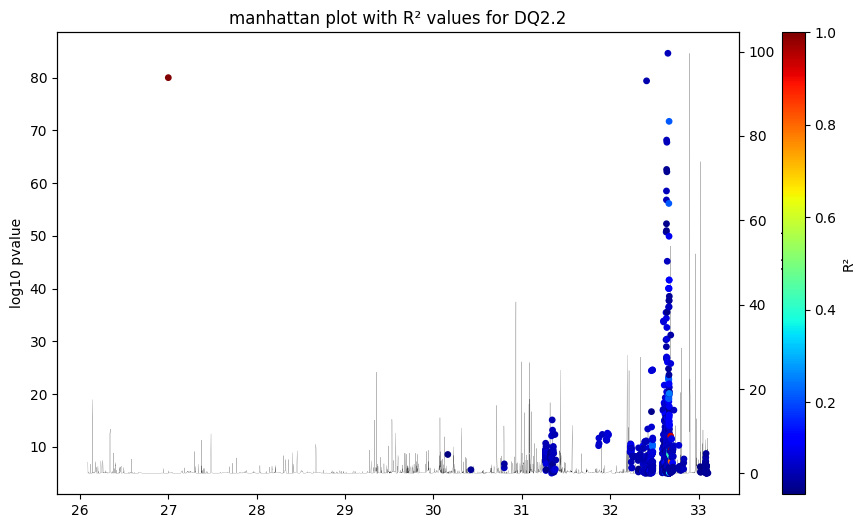

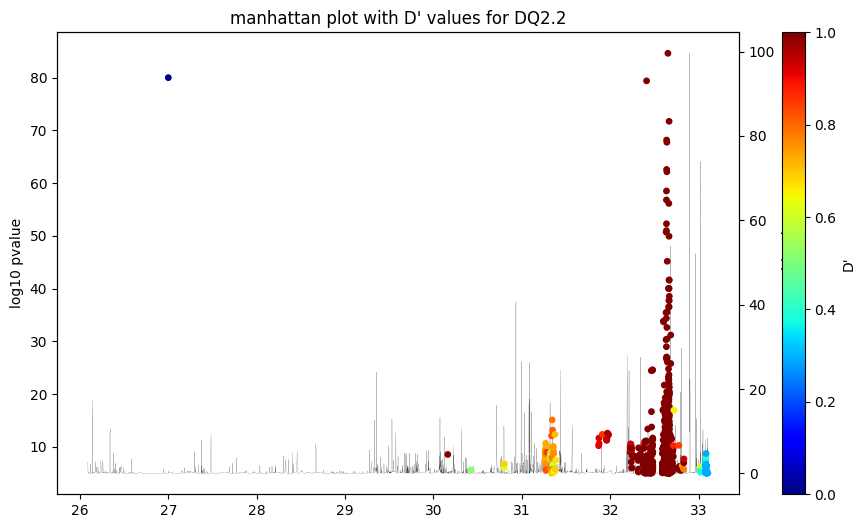

In [71]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['pdf.fonttype']=42

# Quick data check
print(link_MHC.head())
data=link_MHC[link_MHC['SNP2'].isin(DQ22)]
data['POS']=data['POS']/1e6
data=data[data['SNP2']!='chr6:34081891:A:T']
highlight_text='DQ2.2'

data.loc[5000]={'POS':27,'logp':80,'R2':1,'D':0}
# Plot 1: R² vs Position
fig,ax1=plt.subplots(figsize=(11, 6))
# Create a secondary y-axis for R2 values
ax2 = ax1.twinx()
plt.scatter(data['POS'], data['logp'], c=data['R2'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label('R²')
ax2.set_xlabel('Genomic Position (POS) in Mb')
ax2.set_ylabel('log10 pvalue')
plt.title(f'manhattan plot with R² values for {highlight_text}')
plt.xscale('linear')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

ax1.set_ylabel('Recombination', color='k')
ax1.plot(recomb['POS'], recomb['Rate(cM/Mb)'], linestyle='-',linewidth=0.1, color='k', label='Recombination rate')
ax1.tick_params(axis='y', labelcolor='k')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
#plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='y = 0.5')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig(f'{highlight_text}_R2_pval_max.pdf',format='pdf',bbox_inches='tight')
plt.show()

# Plot 2: D vs Position
fig,ax1=plt.subplots(figsize=(11, 6))
# Create a secondary y-axis for R2 values
ax2 = ax1.twinx()

plt.scatter(data['POS'], data['logp'], c=data['D'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label("D'")
ax2.set_xlabel('Genomic Position (POS) in Mb')
ax2.set_ylabel("log10 pvalue")
plt.title(f"manhattan plot with D' values for {highlight_text}")
plt.xscale('linear')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

ax1.set_ylabel('Recombination', color='k')
ax1.plot(recomb['POS'], recomb['Rate(cM/Mb)'], linestyle='-',linewidth=0.1, color='k', label='Recombination rate')
ax1.tick_params(axis='y', labelcolor='k')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
#plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='y = 0.8')
#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig(f'{highlight_text}_Dprime_pval_max.pdf',format='pdf',bbox_inches='tight')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.rcParams['pdf.fonttype']=42

# Quick data check
print(link_MHC.head())
data=link_MHC[(link_MHC['D']>0.7)|(link_MHC['D']==link_MHC['D'].min())]


highlight_text='DQ2.2'
# Plot 1: R² vs Position
plt.figure(figsize=(11, 6))
plt.scatter(data['POS'], data['logp'], c=data['R2'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label('R²')
plt.xlabel('Genomic Position (POS)')
plt.ylabel('log10 pvalue')
plt.title(f'manhattan plot with R² values for {highlight_text}')
plt.xscale('linear')
#plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='y = 0.5')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig(f'{highlight_text}_R2_pval_0.7.pdf',format='pdf',bbox_inches='tight')
plt.show()

# Plot 2: D vs Position
plt.figure(figsize=(11, 6))
plt.scatter(data['POS'], data['logp'], c=data['D'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label("D'")
plt.xlabel('Genomic Position (POS)')
plt.ylabel("log10 pvalue")
plt.title(f"manhattan plot with D' values for {highlight_text}")
plt.xscale('linear')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
#plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='y = 0.8')
#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig(f'{highlight_text}_Dprime_pval_0.7.pdf',format='pdf',bbox_inches='tight')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.rcParams['pdf.fonttype']=42

# Quick data check
print(link_MHC_22.head())
data=link_MHC_22[(link_MHC_22['chr6:32691805:A:G']>0.7)|(link_MHC_22['chr6:32691805:A:G']==link_MHC_22['chr6:32691805:A:G'].min())]
print(len(data))


highlight_text='rs4713586'
# Plot 1: R² vs Position
plt.figure(figsize=(11, 6))
plt.scatter(data['POS'], data['logp'], c=data['chr6:32691805:A:G'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label("D'")
plt.xlabel('Genomic Position (POS)')
plt.ylabel('log10 pvalue')
plt.title(f"manhattan plot with D' values for {highlight_text}")
plt.xscale('linear')
#plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='y = 0.5')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig(f'{highlight_text}_R2_pval_0.6.pdf',format='pdf',bbox_inches='tight')
plt.show()


highlight_text='rs7775228'
data=link_MHC_22[(link_MHC_22['chr6:32690302:T:C']>0.7)|(link_MHC_22['chr6:32690302:T:C']==link_MHC_22['chr6:32690302:T:C'].min())]
print(len(data))
# Plot 2: D vs Position
plt.figure(figsize=(11, 6))
plt.scatter(data['POS'], data['logp'], c=data['chr6:32690302:T:C'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label("D'")
plt.xlabel('Genomic Position (POS)')
plt.ylabel("log10 pvalue")
plt.title(f"manhattan plot with D' values for {highlight_text}")
plt.xscale('linear')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
#plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='y = 0.8')
#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig(f'{highlight_text}_Dprime_pval_0.6.pdf',format='pdf',bbox_inches='tight')

plt.show()

highlight_text='rs2395182'
data=link_MHC_22[(link_MHC_22['chr6:32445540:G:T']>0.7)|(link_MHC_22['chr6:32445540:G:T']==link_MHC_22['chr6:32445540:G:T'].min())]
print(len(data))
# Point to highlight
highlight_index = 1305  # Index of the point to highlight (zero-based)
highlight_x = data.loc[highlight_index,'POS']
highlight_y = data.loc[highlight_index,'logp']
# Plot 2: D vs Position
plt.figure(figsize=(11, 6))
plt.scatter(data['POS'], data['logp'], c=data['chr6:32445540:G:T'],cmap='jet', alpha=1, s=15)
cbar=plt.colorbar()
cbar.set_label("D'")
# Highlight the specific point with a different color
plt.scatter(highlight_x, highlight_y, color='fuchsia', s=25, label='Highlighted Point',edgecolor='k')

# Add a label for the highlighted point
plt.annotate(highlight_text, (highlight_x, highlight_y), 
             textcoords="offset points", xytext=(10, 10), ha='left', color='fuchsia')

plt.xlabel('Genomic Position (POS)')
plt.ylabel("log10 pvalue")
plt.title(f"manhattan plot with D' values for {highlight_text}")
plt.xscale('linear')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
#plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='y = 0.8')
#plt.grid(True, which="both", ls="--", lw=0.5)
plt.savefig(f'{highlight_text}_Dprime_pval_0.6.pdf',format='pdf',bbox_inches='tight')

plt.show()

In [ ]:
allelefreq=pd.read_csv('LD_Euro.frq',sep='\s+')
allelefreq['Reflen']=[len(i) for i in allelefreq['A1']]
allelefreq['Altlen']=[len(i) for i in allelefreq['A2']]
multi_SNP=allelefreq[~allelefreq['A1'].isin(['A','G','C','T'])&(allelefreq['Reflen']==allelefreq['Altlen'])]
multi_SNP['Ref']=[i[0] for i in multi_SNP['A1']]
multi_SNP['Alt']=[i[0] for i in multi_SNP['A2']]
loc = multi_SNP['SNP'].str.split(':',expand=True)[[0,1]]
locus=loc[0]+':'+loc[1]
SNP2=locus+':'+multi_SNP['Ref']+':'+multi_SNP['Alt']
allelefreq.loc[~allelefreq['A1'].isin(['A','G','C','T'])&(allelefreq['Reflen']==allelefreq['Altlen']),'SNP']=SNP2
allelefreq.rename({'SNP':'SNP2'},axis=1,inplace=True)

Alswitch=link_MHC.loc[~link_MHC['SNP2'].isin(link_MHC['SNP2']),'SNP2'].str.split(':',expand=True)

link_MHC.loc[~link_MHC['SNP2'].isin(allelefreq['SNP2']),'SNP2']=Alswitch[0]+':'+Alswitch[1]+':'+Alswitch[3]+':'+Alswitch[2]
LD_union_maf=pd.merge(link_MHC,allelefreq[['SNP2','MAF','NCHROBS']],on='SNP2')
LD_union_maf#.to_csv(f'LD_MAF_{highlight_text}.csv',index=False)

In [7]:
SNPs = pd.read_csv('all_DQ_Dprime.csv')
SNPs.drop(3452,inplace=True)
SNPs[SNPs['DQ2.2']>0.7]

,SNP2,chr6:32638107:C:T,chr6:32713706:T:C,DQ2.2,max_D_SNP
153,chr6:30162257:C:A,0.641911,0.180463,1.000000,DQ2.2
211,chr6:31029915:G:C,0.686749,0.772341,0.756877,chr6:32713706:T:C
446,chr6:31268338:C:T,0.678950,0.473484,0.758205,DQ2.2
447,chr6:31268539:G:T,0.688661,0.659586,0.741641,DQ2.2
448,chr6:31268562:T:C,0.689006,0.658886,0.740826,DQ2.2
...,...,...,...,...,...
3213,chr6:32809144:T:C,0.975532,1.000000,1.000000,chr6:32713706:T:C
3214,chr6:32815309:A:G,0.682519,0.605011,0.730081,DQ2.2
3215,chr6:32830954:C:T,0.628298,0.057308,0.779944,DQ2.2
3216,chr6:32832068:T:G,0.884631,1.000000,1.000000,chr6:32713706:T:C
